# Introdução ao Agrupamento Espectral

Fonte da aula de hoje:
1. Capítulo 16 do *Livro Data Mining and Machine Learning: Fundamental Concepts and Algorithms* (https://dataminingbook.info/book_html/)

Por questão de tempo, faremos apenas uma versão bem **diluída** do capítulo acima. No entanto, apesar de longo, a matemática é acessível a vocês. Aos que quiserem se aprofundar, recomendo a leitura.

*Nothing funny about spectral clustering, no meme today, move on...*

## O Problema de agrupamento

Dada uma coleção de objetos $X = \{x_1, x_2, \dots, x_n\}$, o objetivo é dividir os elementos de $X$ em grupos de forma que:
1. Elementos do mesmo grupo **sejam** "similares"
2. Elementos de grupos diferentes **não sejam** "similares"

Dentro de aprendizado de máquina, o problema de agrupamento está na categoria de **aprendizado não supervisionado**. Essa denominação é dada pois o objetivo é aprender a partir de dados não rotulados.

Até agora, não vimo um método capaz de se sair bem em todos os casos abaixo.

É possível fazer melhor? Na aula de hoje veremo um paradigma de agrupamento completamente diferente.

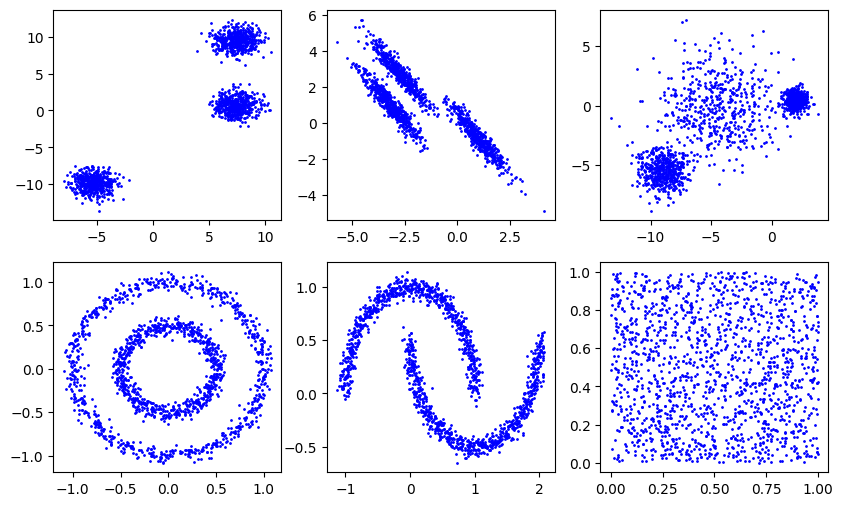

In [ ]:
#@title
import numpy as np
from sklearn import cluster, datasets
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
n_samples = 1500

# circles
noisy_circles, _ = datasets.make_circles(n_samples=n_samples, factor=.5,
                                         noise=.05)

# moons
noisy_moons, _ = datasets.make_moons(n_samples=n_samples, noise=.05)

# blobs
blobs, _ = datasets.make_blobs(n_samples=n_samples, random_state=8)

# no structure
no_structure = np.random.rand(n_samples, 2)

# elipses
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = X_aniso

# blobs with varied variances
varied, _ = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

def plot_figure_example(color):
  f, axarr = plt.subplots(2, 3, figsize=(10, 6))
  axarr[0, 0].scatter(blobs[:, 0], blobs[:, 1], s = 1, c = color[0])
  axarr[0, 1].scatter(aniso[:, 0], aniso[:, 1], s = 1, c = color[1])
  axarr[0, 2].scatter(varied[:, 0], varied[:, 1], s = 1, c = color[2])
  axarr[1, 0].scatter(noisy_circles[:, 0], noisy_circles[:, 1], s = 1,
                      c = color[3])
  axarr[1, 1].scatter(noisy_moons[:, 0], noisy_moons[:, 1], s = 1, c = color[4])
  axarr[1, 2].scatter(no_structure[:, 0], no_structure[:, 1], s = 1,
                      c = color[5])

plot_figure_example([["blue"] for _ in range(6)])

# Agrupamento em Grafos

## Parte I: Motivação

Vamos começar a aula de hoje com uma pergunta diferente. Dado um grafo, $G$, como podemos encontrar "comunidades" em $G$?

Informalmente, o que é uma comunidade em um grafo?

### Exemplo I

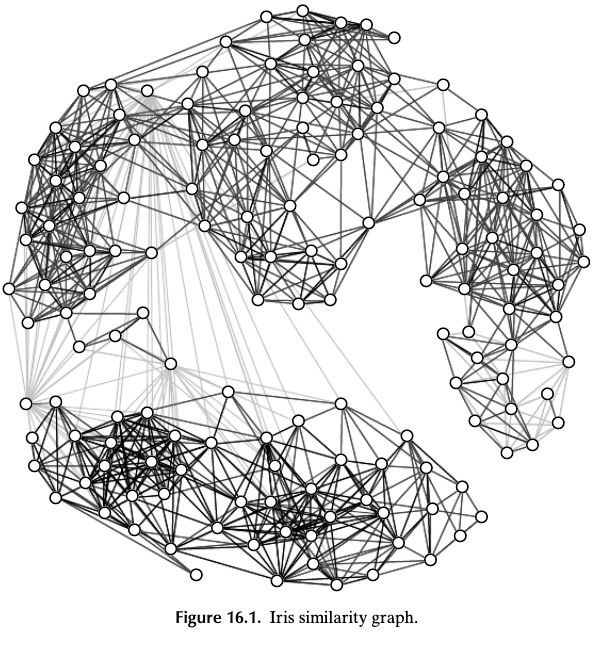

### Exemplo II

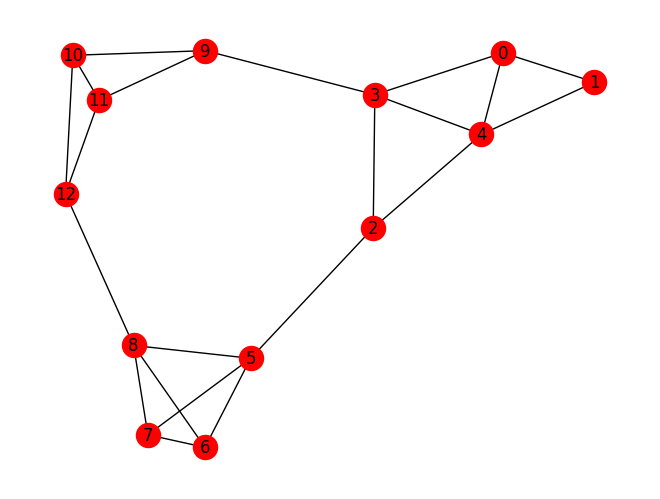

In [ ]:
#@title
import networkx as nx
nodes = list(range(13))
edges = [(0, 1), (0, 3), (0, 4), (1, 4), (2, 3), (2, 4), (2, 5), (3, 4),
         (3, 9), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8), (8, 12),
         (9, 10), (9, 11), (10, 11), (10, 12), (11, 12)]
labels = dict([(x, str(x)) for x in nodes])
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos = pos, labels = labels, node_color='r')
plt.draw()

## Parte II: A matriz Laplaciana e sua importância

Vamos considerar uma versão simplificada do grafo acima.

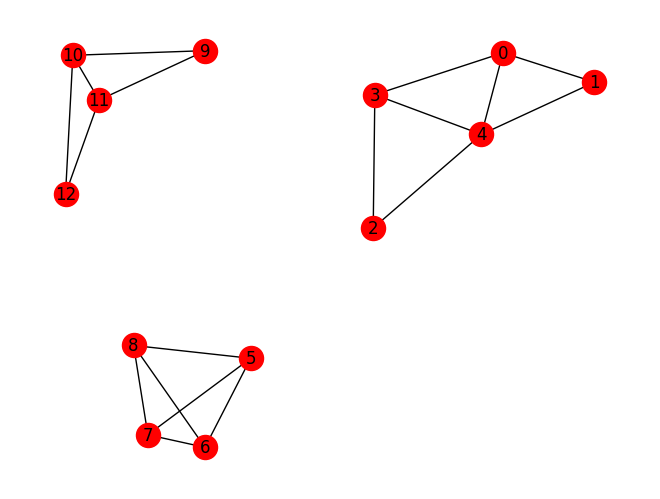

In [ ]:
#@title
nodes = list(range(13))
edges = [(0, 1), (0, 3), (0, 4), (1, 4), (2, 3), (2, 4), (3, 4),
         (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8), (9, 10), (9, 11),
         (10, 11), (10, 12), (11, 12)]
labels = dict([(x, str(x)) for x in nodes])
H = nx.Graph()
H.add_nodes_from(nodes)
H.add_edges_from(edges)
nx.draw(H, pos = pos, labels = labels, node_color = 'r')
plt.draw()

Considere $A$, a matriz de adjacências de $G$.

In [ ]:
A = nx.to_numpy_array(H)
A

array([[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.]])

Considere $\Delta$, a matriz de graus de $G$.

In [ ]:
d = A.sum(axis = 1)
D = np.diag(np.squeeze(np.asarray(d)))
D

array([[3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 4., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 3., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]])

A Matriz Laplaciana de $G$, denotada por $L$, é dada por
$$L = \Delta - A$$

In [ ]:
L = D - A
L

array([[ 3., -1.,  0., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  2.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  2., -1., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1.,  0., -1.,  3., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  3., -1., -1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1.,  3., -1., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1., -1.,  3., -1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0., -1., -1., -1.,  3.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2., -1., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  3., -1., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  3., -1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1., -1.,  2.]])

Veja que a matriz Laplaciana do grafo possui uma estrutura bloco-diagonal. Além disso, considere os três vetores definidos a seguir.

In [ ]:
u = np.concatenate([np.ones(5), np.zeros(8)])
v = np.concatenate([np.zeros(5), np.ones(4), np.zeros(4)])
w = np.concatenate([np.zeros(9), np.ones(4)])
print(u)
print(v)
print(w)

[1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.]


In [ ]:
np.dot(L, u) # Lu = 0u

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
np.dot(L, v) # Lv = 0v

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
np.dot(L, w) # Lw = 0w

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Esses três vetores são autovetores de $L$ associados ao autovalor zero!

**Por que isso é importante?**
Esses vetores indicam a estrutura de cada comunidade do grafo.

**Há uma relação muito forte entre a estrutura de comunidades de um grafo e o espectro da matriz Laplaciana!**

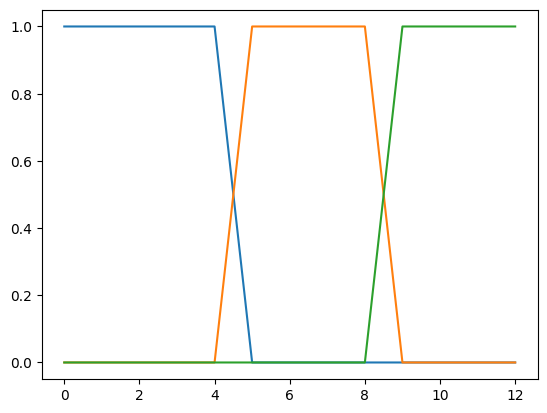

In [ ]:
plt.plot(u)
plt.plot(v)
plt.plot(w);

## Parte III: Formalização do Problema

### O Grafo

Nossa entrada será um grafo $G(V, E, \omega)$, simples, ponderado e não direcionado, aonde:
- $V = \{x_1, \dots, x_n\}$ é o conjunto de vértices
- $E$ é o conjunto de arestas
- Dada uma aresta $e = (x_i, x_j) \in E$, $\omega((x_i, x_j))$ representa a **similaridade** entre os nós $x_i$ e $x_j$.

A **matriz de adjacências** de $G$ é a matriz $A$, tal que
$$a_{ij} = \omega((x_i, x_j)).$$

A **matriz de graus** de $G$ é a matriz $\Delta$, tal que
$$
\delta_{ij} = \begin{cases}
\sum_{k = 1}^na_{ik},\ \ \ \ i = j\\
0, \ \ \ \ \text{caso contrário}.
\end{cases}
$$

Novamente, a **matriz Laplaciana** de $G$ é a matriz $L$, tal que
$$L = \Delta - A$$

### Um $k$-corte do grafo

Dado um grafo $G(V, E, \omega)$, um $k$-corte de $G$ é uma partição de $V$ em $k$ subconjuntos. Vamos denotar essa partição por $C = \{C_1, C_2, \dots, C_k\}$.

Sejam $S$ e $T$ dois subconjuntos de $V$. Vamos definir a soma dos pesos das arestas com um vértice em $S$ e outro em $T$ por $W(S, T)$. Ou seja,
$$W(S, T) = \sum_{x\in S}\sum_{y \in T} \omega((x, y)).$$

Seja $S$ um subconjunto de $V$. Denotamos $\bar{S} = V \setminus S$.

Como poderíamos definir um bom $k$-corte de $G$? Ou seja, como podemos encontrar um $k$-corte de $G$ que capture a estrutura de comunidades de $G$?

**Há várias formas de responder essa pergunta. Hoje, veremos uma das mais simples. Essa versão dá uma excelente intuição de como agrupamento espectral funciona, mas não necessariamente é a que está implementada nas bibliotecas.
Consulte o livro texto para mais detalhes...**

#### Um bom $k$-corte

Estamos interessados em encontrar um $k$-corte $C = \{C_1, C_2, \dots, C_k\}$ com as seguinte propriedades:
- $W(C_i, \bar{C}_i)$ é uma quantidade pequena, para $i = 1, \dots, k$.
- $|C_i|$ é uma quantidade grande, para $i = 1, \dots, k$.

Em outras palavras, queremos $C = \{C_1, C_2, \dots, C_k\}$ que minimize
$$\sum_{i = 1}^k\frac{W(C_i, \bar{C}_i)}{|C_i|}.$$

Agora precisamos reescrever a quantidade acima em função de algumas coisas que já conhecemos... Defina o vetor $\mathbf{c}_i \in \{0, 1\}^n$ da seguinte forma:
$$c_{ij} = \begin{cases}
1,\ \text{se } x_j \in C_i\\
0, \ \text{caso contrário}.
\end{cases}
$$
Em outras palavras, $\mathbf{c}_i$ é um vetor binário que indica quais vértices de $V$ estão em $C_i$.

**Exemplo:**
- $V = \{0, 1, 2, 3, 4, 5, 6, 7, 8, 9\}$,
- $C_1 = \{0, 1, 2, 3\}$ e
- $C_2 = \{4, 5, 6, 7, 8, 9\}$.

Então:
- $\mathbf{c}_1 = [1, 1, 1, 1, 0, 0, 0, 0, 0, 0]$ e
- $\mathbf{c}_2 = [0, 0, 0, 0, 1, 1, 1, 1, 1, 1]$.



Com isso, é possível mostrar que (e só não vamos fazer por questões de tempo)
$$\sum_{i = 1}^k\frac{W(C_i, \bar{C}_i)}{|C_i|} =\dots = \sum_{i = 1}^k\frac{\mathbf{c}_i^TL\mathbf{c}_i}{\mathbf{c}_i^T\mathbf{c}_i} = \sum_{i = 1}^k\frac{\mathbf{c}_i^TL\mathbf{c}_i}{\Vert\mathbf{c}_i\Vert_2^2}$$

Em resumo, estamos interessados no problema de otimização descrito abaixo:

$$\text{Minimizar }\sum_{i = 1}^k\frac{\mathbf{c}_i^TL\mathbf{c}_i}{\mathbf{c}_i^T\mathbf{c}_i}$$
Com restrições:
- $\mathbf{c}_i$ é um vetor binário, $i = 1, \dots, k$;
- $\Vert\mathbf{c}_i\Vert_2 > 0$, $i = 1, \dots, k$;
- $\mathbf{c}_i^T\mathbf{c}_j = 0$, $i \neq j$;
- $\sum_{i,j}c_{ij} = n$.

## Parte IV: Solução e Algoritmo

### Relaxamento do Problema

O problema de otimização descrito acima não é trivial (pelo que se sabe hoje). De fato, é um problema NP-difícil...

Vamos fazer o seguinte:
1. Vamos "relaxar" o problema. Ou seja, vamos permitir que $\mathbf{c}_i$ seja um vetor real;
2. Vamos definir $\mathbf{u}_i = \frac{\mathbf{c}_i}{\Vert\mathbf{c}_i\Vert_2}$.

Assim, a versão relaxada do problema de otimização que temos em mãos é:

$$\text{Minimizar}\sum_{i = 1}^k\mathbf{u}_i^TL\mathbf{u}_i$$

Com restrições:
- $\mathbf{u}_i^T\mathbf{u}_i = 1, \ i = 1, \dots, k$
- $\mathbf{u}_i^T\mathbf{u}_j = 0, \ i \neq j$.

### Solução do problema relaxado

Num espírito muito similar à solução do PCA, a solução do problema anterior é dada por:
- **os $k$ autovetores de $L$ associados aos $k$ menores autovalores de $L$**

A ideia é que a solução do problema relaxado capture o **sinal** das comunidades.

In [ ]:
nodes = list(range(13))
edges = [(0, 1), (0, 3), (0, 4), (1, 4), (2, 3), (2, 4), (3, 4),
         (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8), (9, 10), (9, 11),
         (10, 11), (10, 12), (11, 12)]

edges = [(0, 1), (0, 3), (0, 4), (1, 4), (2, 3), (2, 4), (2, 5), (3, 4),
         (3, 9), (5, 6), (5, 7), (5, 8), (6, 7), (6, 8), (7, 8), (8, 12),
         (9, 10), (9, 11), (10, 11), (10, 12), (11, 12)]

labels = dict([(x, str(x)) for x in nodes])
H = nx.Graph()
H.add_nodes_from(nodes)
H.add_edges_from(edges)

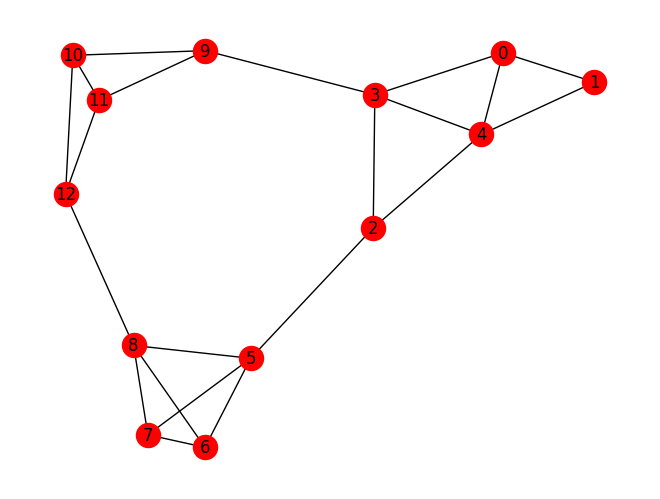

In [ ]:
#@title
nx.draw(H, pos = pos, labels = labels, node_color = 'r')
plt.draw()

In [ ]:
# A
A = nx.to_numpy_array(H)

# D
d = A.sum(axis = 1)
D = np.diag(np.squeeze(np.asarray(d)))

# L
L = D - A

In [ ]:
A

array([[0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0.]])

In [ ]:
from numpy import linalg as LA
w, v = LA.eigh(L)

In [ ]:
U = v[:, :3]
u1 = U[:, 0] # Autovetor associado ao menor autovalor
u2 = U[:, 1] # Autovetor associado ao segundo menor autovalor
u3 = U[:, 2] # Autovetor associado ao terceiro menor autovalor

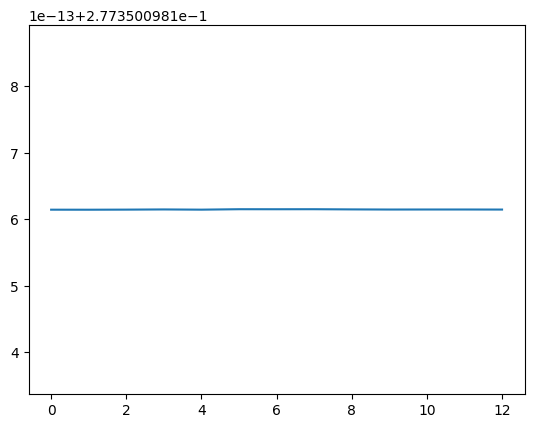

In [ ]:
plt.plot(u1);

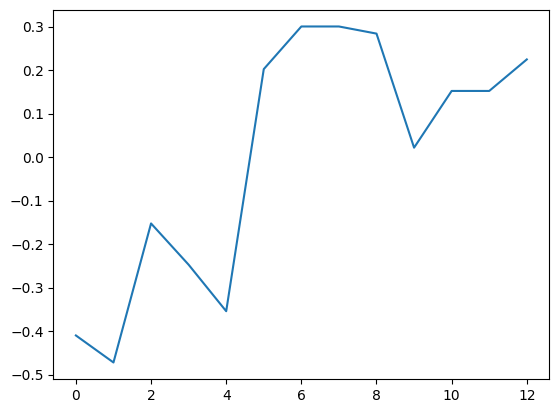

In [ ]:
plt.plot(u2);

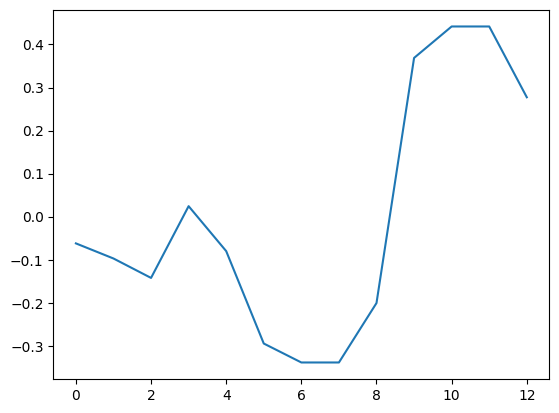

In [ ]:
plt.plot(u3);

### Algoritmo

Com as observaçõe acima, o agrupamento espectral consiste dos seguintes passos (**versão resumida**):
1. Dado um grafo $G$ e um inteiro $k$, compute a matriz Laplaciana $L$;
2. Obtenha os $k$ autovetores associados aos menores autovalores de $L$. Denote esses vetores por $\mathbf{u}_1, \dots, \mathbf{u}_k$;
3. Construa a matriz $\mathbf{U}$, cujas colunas são $\mathbf{u}_1, \dots, \mathbf{u}_k$;
4. Aplique algum algoritmo de agrupamento já conhecido (e.g., $k$-means) na matriz $\mathbf{U}$. Os índices das linhas pertencentes aos mesmos grupos definem os índices dos vértices pertencentes às mesmas comunidades.

# De grafos para matrizes de dados

Discutimos como encontrar comunidades em grafos, no entanto, nessa disciplina, queremos encontrar grupos de "objetos" similares. Lembre, nosso problem é o seguinte:

Dada uma coleção de objetos $X = \{x_1, x_2, \dots, x_n\}$, o objetivo é dividir os elementos de $X$ em grupos de forma que:
1. Elementos do mesmo grupo **sejam** "similares"
2. Elementos de grupos diferentes **não sejam** "similares"

Bom, precisamos então de uma forma para criar um grafo a partir do nosso conjunto de dados. Há várias formas de fazer isso, a mais comum é construir um grafo de vizinhos mais próximos.

Dado um inteiro $m$ (um hiperparâmetro a ser escolhido pelo usuário do algoritmo):
1. O vértices do grafo são os elementos a serem agrupados;
2. Conecte cada vértice aos $m$ vértices mais similares (de acordo com alguma função de similaridade). Isso define o conjunto de arestas.
3. Aplique Agrupamento Espectral no grafo formado.

# Na biblioteca ``scikit-learn``

Tudo isso que discutimos (e muito mais) vira uma linha de código =)

**WARNING:** A ``scikit-learn`` usa uma versão diferente do que discutimos. De fato, eles usam a Laplaciana Normalizada. A intuição geral do que discutimos é válida, mas não é o que está implementado na biblioteca.

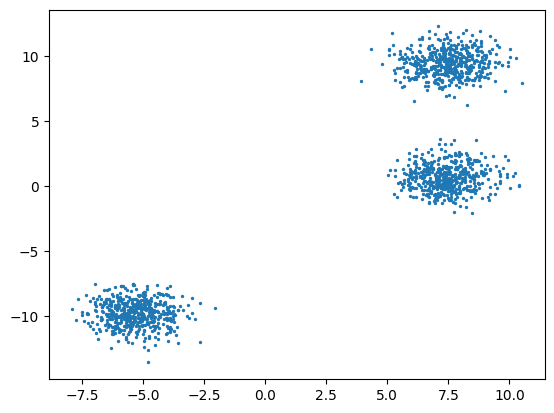

In [ ]:
#@title
import numpy as np
from sklearn import cluster, datasets
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(0)
n_samples = 1500

blobs, _ = datasets.make_blobs(n_samples=n_samples, random_state=8)
_ = plt.scatter(blobs[:, 0], blobs[:, 1], s = 2);

In [ ]:
from sklearn.cluster import SpectralClustering

m = SpectralClustering(n_clusters = 3, affinity = 'nearest_neighbors', n_neighbors = 10)
#m = SpectralClustering(n_clusters = 3)
m.fit(blobs)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


SpectralClustering(affinity='nearest_neighbors', n_clusters=3)

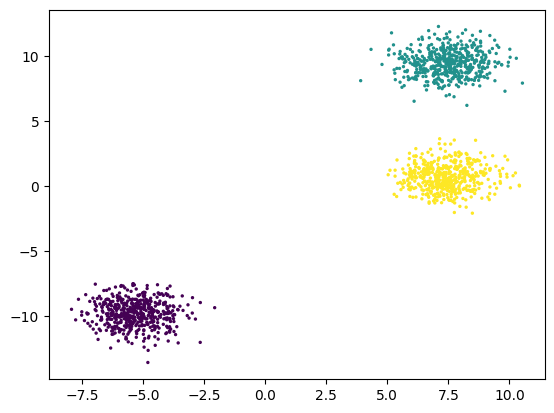

In [ ]:
#@title
plt.scatter(blobs[:, 0], blobs[:, 1], c=m.labels_, s = 2, cmap='viridis');

## E para nossos testes?

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


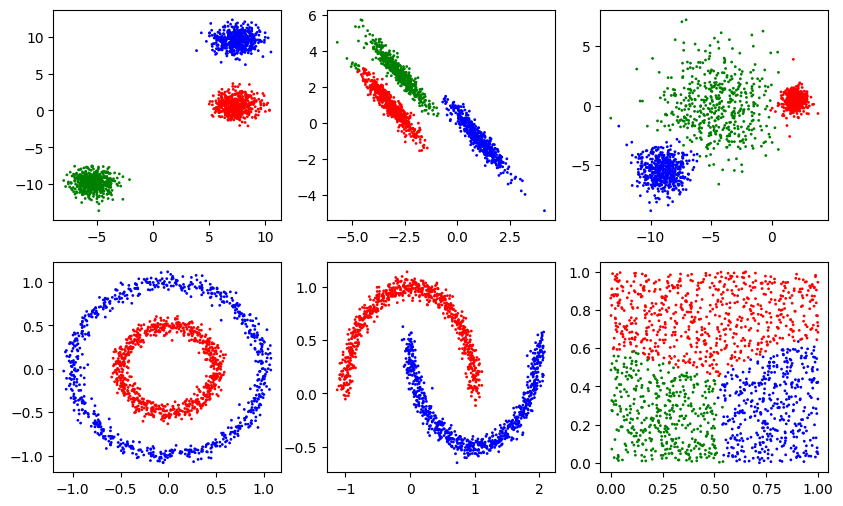

In [ ]:
#@title
def exec_model(dataset, model, params):
  labels = []
  if model == cluster.DBSCAN:
    for idx, param in enumerate(params):
      km = model(eps = param[0], min_samples = param[1])
      km.fit(dataset[idx])
      labels.append(km.labels_)
  elif model == cluster.SpectralClustering:
    for idx, param in enumerate(params):
      km = model(param, affinity='nearest_neighbors')
      km.fit(dataset[idx])
      labels.append(km.labels_)
  else:
    for idx, param in enumerate(params):
      km = model(param)
      km.fit(dataset[idx])
      labels.append(km.labels_)
  color = "blue red green yellow black purple".split()
  c = []
  for label in labels:
    c.append([color[w] for w in label])
  return c

dataset = [blobs, aniso, varied, noisy_circles, noisy_moons, no_structure]
n_groups = [3, 3, 3, 2, 2, 3]
colors = exec_model(dataset, cluster.SpectralClustering, n_groups)
plot_figure_example(colors)

# What is next?

- Como avaliar se um agrupamento é bom?